# Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Project 1: Virtual Paint

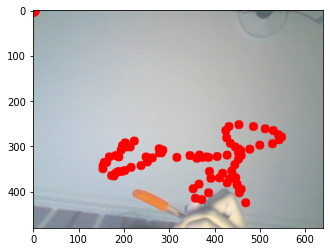

In [30]:
frameWidth = 640
frameHeight = 480
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10,150)          # set brightness
 
myColors = [[5,107,0,19,255,255],       # colors range
            [133,56,0,159,156,255],
            [57,76,0,100,255,255],
            [90,48,0,118,255,255]]
myColorValues = [[51,153,255],          ## BGR
                 [255,0,255],
                 [0,255,0],
                 [255,0,0]]
 
myPoints =  []  ## [x , y , colorId ]
 
def findColor(img,myColors,myColorValues):
    imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    count = 0
    newPoints=[]
    for color in myColors:
        lower = np.array(color[0:3])
        upper = np.array(color[3:6])
        mask = cv2.inRange(imgHSV,lower,upper)
        x,y=getContours(mask)
        cv2.circle(imgResult,(x,y),15,myColorValues[count],cv2.FILLED)
        if x!=0 and y!=0:
            newPoints.append([x,y,count])
        count +=1
        #cv2.imshow(str(color[0]),mask)
    return newPoints
 
def getContours(img):
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    x,y,w,h = 0,0,0,0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area>2000:
            #cv2.drawContours(imgResult, cnt, -1, (255, 0, 0), 3)
            peri = cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            x, y, w, h = cv2.boundingRect(approx)
    return x+w//2,y
 
def drawOnCanvas(myPoints,myColorValues):
    for point in myPoints:
        cv2.circle(imgResult, (point[0], point[1]), 10, myColorValues[point[2]], cv2.FILLED)
 
 
while True:
    success, img = cap.read()
    imgResult = img.copy()
    newPoints = findColor(img, myColors,myColorValues)
    if len(newPoints)!=0:
        for newP in newPoints:
            myPoints.append(newP)
    if len(myPoints)!=0:
        drawOnCanvas(myPoints,myColorValues)
 
 
    cv2.imshow("Result", imgResult)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
         break
plt.imshow(imgResult)
plt.show()
cv2.destroyAllWindows()
cap.release()

# Project 2: Document Scanner

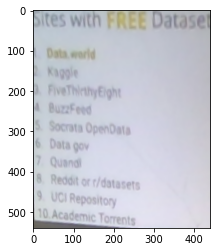

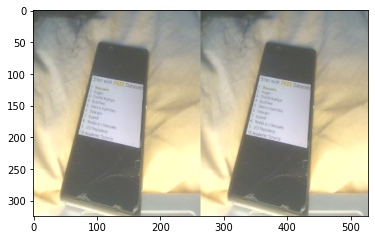

In [19]:
###################################
widthImg=440
heightImg =540
#####################################
 
cap = cv2.VideoCapture(0)
cap.set(10,100)
 
def preProcessing(img):
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
    imgCanny = cv2.Canny(imgBlur,200,200)                   # detect edges
    kernel = np.ones((5,5))
    imgDial = cv2.dilate(imgCanny,kernel,iterations=2)      # make edges more thicker
    imgThres = cv2.erode(imgDial,kernel,iterations=1)       # make edges more thinner
    return imgThres
 
def getContours(img):
    biggest = np.array([])
    maxArea = 0
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area>800:
            #cv2.drawContours(imgContour, cnt, -1, (255, 0, 0), 3)
            peri = cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)       # get corner points
            if area >maxArea and len(approx) == 4:
                biggest = approx
                maxArea = area
    cv2.drawContours(imgContour, biggest, -1, (255, 0, 0), 20)   # draw contour for biggest object
    return biggest
 
def reorder (myPoints):
    myPoints = myPoints.reshape((4,2))
    myPointsNew = np.zeros((4,1,2),np.int32)
    add = myPoints.sum(1)
    #print("add", add)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints,axis=1)
    myPointsNew[1]= myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    #print("NewPoints",myPointsNew)
    return myPointsNew
 
def getWarp(img,biggest):
    biggest = reorder(biggest)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0, 0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgOutput = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
 
    imgCropped = imgOutput[20:imgOutput.shape[0]-20,20:imgOutput.shape[1]-20]
    imgCropped = cv2.resize(imgCropped,(widthImg,heightImg))
 
    return imgCropped


def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver
 
while True:
    success, img = cap.read()
    img = cv2.resize(img,(widthImg,heightImg))
    imgContour = img.copy()
    flag=0
    imgThres = preProcessing(img)
    biggest = getContours(imgThres)
    if biggest.size !=0:
        flag=1
        imgWarped=getWarp(img,biggest)         # get target object
        # imageArray = ([img,imgThres],
        #           [imgContour,imgWarped])
        imageArray = ([imgContour, imgWarped])
        cv2.imshow("ImageWarped", imgWarped)
        plt.imshow(imgWarped)
        plt.show()
        
    else:
        # imageArray = ([img, imgThres],
        #               [img, img])
        imageArray = ([imgContour, img])
        
    if flag==1:
        break
    stackedImages = stackImages(0.6,imageArray)
    cv2.imshow("WorkFlow", stackedImages)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
         break
    
if flag==1:
    plt.imshow(stackedImages)
    plt.show()
    cv2.imshow("Result", imgContour)
    plt.show()
    
cv2.destroyAllWindows()
cap.release()

# Project 3: Number Plate Detector

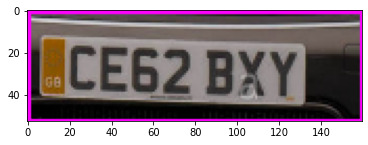

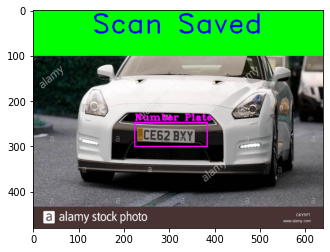

In [6]:
#############################################
frameWidth = 640
frameHeight = 480
nPlateCascade = cv2.CascadeClassifier("haarcascade_russian_plate_number.xml")
minArea = 1000
color = (255,0,255)
###############################################
 
img = cv2.imread('images/car_1.jpg')
img = cv2.resize(img, (frameWidth, frameHeight))
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
numberPlates = nPlateCascade.detectMultiScale(imgGray, 1.1, 10)
for (x, y, w, h) in numberPlates:
    area = w*h
    if area >minArea:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)
        cv2.putText(img,"Number Plate",(x,y-5),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,color,2)
        imgRoi = img[y:y+h,x:x+w]
        #cv2.imshow("ROI", imgRoi)
        plt.imshow(imgRoi)
        plt.show()
        cv2.imwrite("images/NoPlate_0.jpg",imgRoi)
        cv2.rectangle(img,(0,0),(640,100),(0,255,0),cv2.FILLED)
        cv2.putText(img,"Scan Saved",(130,50),cv2.FONT_HERSHEY_DUPLEX,2,(0,0,255),2)
        #cv2.imshow("Result",img)
        plt.imshow(img)
        plt.show()
        cv2.waitKey(0)
        break

cv2.destroyAllWindows()
    